In [16]:
import numpy as np
import pandas as pd
import sklearn.metrics as m
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
# cross validation
from sklearn.model_selection import cross_val_score
# grid search
from sklearn.model_selection import GridSearchCV
# outlier
from sklearn.neighbors import LocalOutlierFactor
# imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [17]:
df = pd.read_csv("dataset/dementia_dataset.csv")
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


# visualization

In [18]:
px.bar(df['SES'].value_counts(), x=df['SES'].value_counts().index, y='SES', title='SES')

In [19]:
px.bar(df['Group'].value_counts(), x=df['Group'].value_counts().index, y='Group', title='Group')

In [20]:
# do other visualization here

In [21]:
df.drop(columns=['MRI ID', 'Subject ID'], inplace=True)

In [22]:






X = df.drop(columns=['Group'])
y = LabelEncoder().fit_transform(df['Group'])

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)



transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

preprocess = Pipeline([
    ('transformer', transformer),
   ('imputer', SimpleImputer(strategy='median'))
])

X_train = preprocess.fit_transform(X_train, y_train)
X_test = preprocess.transform(X_test)
print(cat_cols)
print(num_cols)



Index(['M/F', 'Hand'], dtype='object')
Index(['Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF'],
      dtype='object')


# imbalance data handling

In [23]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)


(426, 11) (426,)


In [24]:
model =  RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)


Fitting 5 folds for each of 2250 candidates, totalling 11250 fits


c:\Users\shashank Mishra\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.97      0.97      0.97        37
           2       0.91      1.00      0.95        48

    accuracy                           0.93        94
   macro avg       0.88      0.77      0.80        94
weighted avg       0.92      0.93      0.91        94



<Axes: >

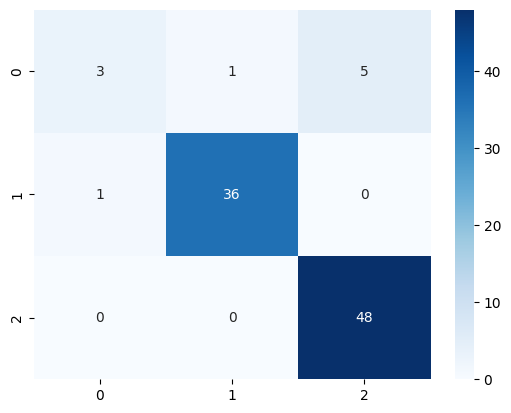

In [25]:
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

model = grid_search.best_estimator_

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

In [26]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('rank_test_score', inplace=True)

results[['params', 'mean_test_score', 'rank_test_score']].head(10)
#save model
import joblib
joblib.dump(model, 'models/model.pkl')

['models/model.pkl']